In [1]:
from PIL import Image, ImageEnhance, ImageDraw, ImageFilter
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

def preprocessing_last(image_path):
    img = np.array(cv2.imread(image_path))
    image = img.copy()
    image[image > 250] = 0
    image = Image.fromarray(image)
    # width, height = image.shape[0], image.shape[1]
    # for corner in [(0,0),(0,height),(width,0),(width, height)]:
    #     color = (0,0,0,0)
    #     ImageDraw.floodfill(image2, xy=corner, value=color,thresh=150)
    #increasing the contrast 20%
    
    image = image.filter(ImageFilter.MinFilter(3))
    image = ImageEnhance.Contrast(image).enhance(2)
    
    # image = ImageEnhance.Sharpness(image2).enhance(1.3)
    # image = ImageEnhance.Brightness(image2).enhance(1.3)
    image = np.array(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = np.zeros(image.shape, np.uint8)
    
    gray = cv2.medianBlur(gray, 5)
    ret, gray = cv2.threshold(gray, 30,255,cv2.THRESH_BINARY)
    # gray = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11,2)
    # ret, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    closing_kernel = np.ones((15,15),np.uint8)
    closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, closing_kernel, iterations=1)
    # closing = cv2.morphologyEx(closing, cv2.MORPH_OPEN, closing_kernel, iterations=1)

    contours, _ = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_area = sorted(contours, key=cv2.contourArea)[-1:]
    cv2.drawContours(mask, largest_area, 0, (255,255,255), cv2.FILLED)
    # print(mask.shape)
    dst = cv2.bitwise_and(img, mask)

    # mask = 255 - mask
    # roi = cv2.add(dst, mask)
    # roi = mask / 255 * dst

    # selection = image.copy()
    # selection[roi == 255] = 0
    
    return image, closing, mask, dst


datasets/RESC/valid/original_images/sn3502_75.bmp


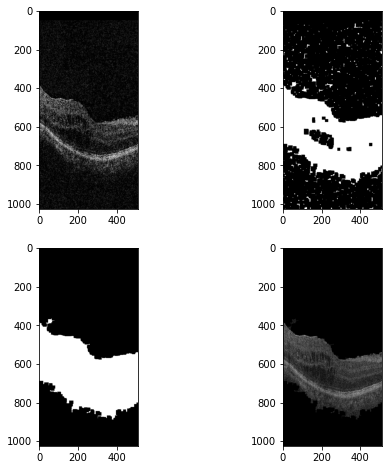

datasets/RESC/valid/original_images/sn3502_81.bmp


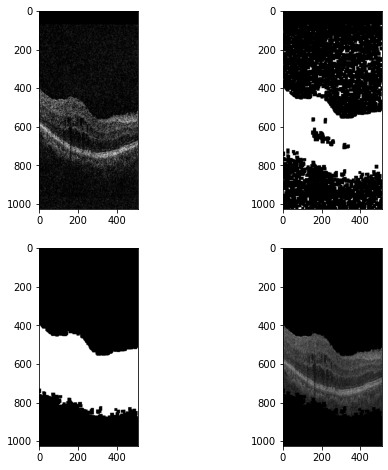

datasets/RESC/valid/original_images/sn3502_6.bmp


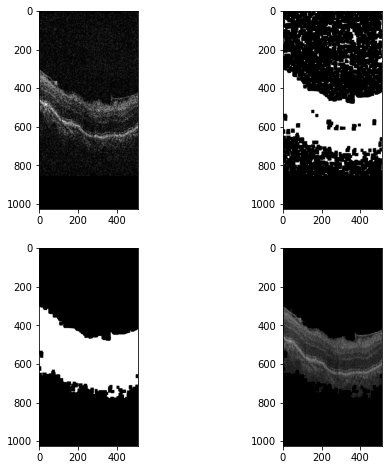

In [4]:
daataset = glob.glob("datasets/RESC/valid/original_images/sn3502_*")
# import random
# random.choice(range(10, 101))
for image_path in daataset[50:53]:
    img, closing, mask, dst = preprocessing_last(image_path)
    print(image_path)
    plt.figure(figsize=(8,8))
    plt.subplot(2,2,1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    # plt.plot(img, camp='gray')
    plt.subplot(2,2,2)
    plt.imshow(closing, cmap='gray', vmin=0, vmax=255)
    # plt.plot(closing)
    plt.subplot(2,2,3)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
    # plt.plot(mask)
    plt.subplot(2,2,4)
    plt.imshow(dst)
    # plt.plot(dst)
    # plt.plot(selection)
    
    plt.show()
    # import pdb; pdb.set_trace()

In [8]:

#(['images', 'automaticFluidDME', 'manualFluid1', 'manualFluid2', 'automaticLayersDME', 'automaticLayersNormal', 'manualLayers1', 'manualLayers2'])

import scipy.io
import numpy as np
fluid_class = 9
mat = scipy.io.loadmat('2015_BOE_Chiu/Subject_0{}.mat'.format(1))
img_tensor = mat['images']
manual_fluid_tensor_1 = np.array(mat['manualFluid1'], dtype=np.uint16)
manual_fluid_tensor_2 = np.array(mat['manualFluid2'], dtype=np.uint16)
layesr = mat['automaticLayersDME']
# print(layesr.shape, np.unique(layesr[0]))
# print(type(img_tensor), img_tensor.shape)
img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))
manual_fluid2_array = np.transpose(manual_fluid_tensor_2, (2, 0, 1))
layesr_array = np.transpose(layesr, (2, 0, 1))

In [2]:
import os
subject_path = [os.path.join('2015_BOE_Chiu', 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join('2015_BOE_Chiu', 'Subject_10.mat')]
print(subject_path)

['2015_BOE_Chiu/Subject_01.mat', '2015_BOE_Chiu/Subject_02.mat', '2015_BOE_Chiu/Subject_03.mat', '2015_BOE_Chiu/Subject_04.mat', '2015_BOE_Chiu/Subject_05.mat', '2015_BOE_Chiu/Subject_06.mat', '2015_BOE_Chiu/Subject_07.mat', '2015_BOE_Chiu/Subject_08.mat', '2015_BOE_Chiu/Subject_09.mat', '2015_BOE_Chiu/Subject_10.mat']


In [18]:
def get_valid_idx(manualLayer):
    idx = []
    for i in range(0,61):
        temp = manualLayer[:,:,i]
        # print(np.unique(temp))
        if np.sum(temp) != 0:
            idx.append(i)
    return idx

In [48]:
# data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]
import scipy.io
import cv2
import numpy as np
for i in range(0,10):
    mat = scipy.io.loadmat(subject_path[i])
    manual_fluid = np.array(mat['manualFluid1'], dtype=np.uint8)
    img_orig = np.array(mat['images'], dtype=np.uint8)
    # print(layesr.shape)
    fluid_existing_index = get_valid_idx(manual_fluid)
    
    for idx in fluid_existing_index:
        annot_img_orig = img_orig[:,:, idx]
        annot_manual_fluid = manual_fluid[:, :, idx] #(496, 768, 11)
        annot_manual_fluid[annot_manual_fluid>0] = 255
        # print(np.unique(annot_manual_fluid), np.unique(annot_img_orig))
        # s
        cv2.imwrite('2015_BOE_Chiu/segment_annotation/images/subject_{}_{}.png'.format(i+1, idx), annot_img_orig)
        cv2.imwrite('2015_BOE_Chiu/segment_annotation/labels/subject_{}_{}.png'.format(i+1, idx), annot_manual_fluid)

In [45]:
annot_manual_fluid.max()

1

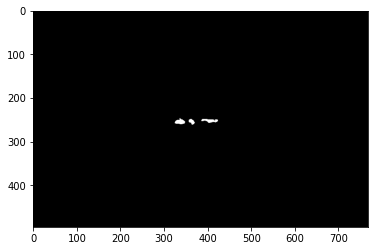

In [47]:
plt.imshow(annot_manual_fluid, cmap='gray' )

In [ ]:
# def get_valid_img_seg(mat):
manualLayer = np.array(mat['manualLayers1'], dtype=np.uint16)
manualFluid = np.array(mat['manualFluid1'], dtype=np.uint16)
img_orig = np.array(mat['images'], dtype=np.uint8)
img = img_orig.copy()
valid_idx = get_valid_idx(manualLayer)

img_orig = img_orig[:,:, valid_idx]
manualFluid = manualFluid[:, :, valid_idx] #(496, 768, 11)
manualLayer = manualLayer[:, :, valid_idx]  #(8, 768, 11)

print(manualLayer.shape, manualFluid.shape)

seg = np.zeros((496, 768, 11))
seg[manualFluid > 0] = fluid_class

max_col = -100
min_col = 900
for b_scan_idx in range(0, 11):
    for col in range(768):
        cur_col = manualLayer[:, col, b_scan_idx]
        if np.sum(cur_col) == 0:
            continue
        # 竖着切一遍, 找到最左边和最右边
        max_col = max(max_col, col)
        min_col = min(min_col, col)
        
        labels_idx = cur_col.tolist()
        
        # print(f'{b_scan_idx} {labels_idx}')
#         labels_idx.append(-1)
#         labels_idx.insert(0, 0)
        last_st = None
        last_ed = None
        for label, (st, ed) in enumerate(zip([0]+labels_idx, labels_idx+[-1])):
            if st == 0 and ed == 0:
                st = last_ed
                # 穿越第一层
                while(seg[st, col, b_scan_idx] == fluid_class):
                    st += 1

                while(seg[st, col, b_scan_idx] != fluid_class):
                    seg[st, col, b_scan_idx] = label
                    st += 1
                    if st >= 496:
                        break
                continue
            if ed == 0:
                ed = st + 1
                while(seg[ed, col, b_scan_idx] != fluid_class):
                    ed += 1
            if st == 0 and label != 0:
                st = ed-1
                while(seg[st, col, b_scan_idx] != fluid_class):
                    st -= 1
                st += 1

            seg[st:ed, col, b_scan_idx] = label
            last_st = st
            last_ed = ed

seg[manualFluid > 0] = fluid_class

seg = seg[:, min_col:max_col+1]
img = img[:, min_col:max_col+1]
# return img, seg

In [ ]:

print(img_array.shape)
import matplotlib.pyplot as plt
# print(np.unique(manual_fluid_array))

for i in range(0,11):
    # print(np.unique(manualFluid[:,:,i]))
    # print(np.unique(manual_fluid_array[i]))
    # print(np.unique(manual_fluid2_array[i]))
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(img_array[i], cmap='gray', vmin=0, vmax=255)
    plt.subplot(1,3,2)
    plt.imshow(manual_fluid_array[i])
    plt.subplot(1,3,3)
    plt.imshow(manual_fluid2_array[i])
    plt.show()